# ResNet

Here is ResNet Woot Woot

# Load DataSets

In [1]:
import tensorflow as tf
import hyperopt as hpropt
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from util import import_dataset, sample_data, plot_confusion_matrix
from multiclass_model import MulticlassModel, lazy_property
from config import ModelConfig, TrainConfig
%matplotlib inline

# Set default to auto import packages
%load_ext autoreload
%autoreload 2

In [2]:
# Form training, developement, and testing data sets
"""
address = r'../../data/smallDataset/'
file_names = {}
file_names['images'] = 'data.npy'
file_names['subs'] = 'subredditlabels'
file_names['dict'] = 'subredditIndex'
file_names['nsfw'] = 'nsfwlabels'
"""
address = r'../../data/fullData/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'

data, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', data.X_train.shape)
print('Train labels shape: ', data.y_train.shape)
print('Validation data shape: ', data.X_val.shape)
print('Validation labels shape: ', data.y_val.shape)
print('Test data shape: ', data.X_test.shape)
print('Test labels shape: ', data.y_test.shape)

Train data shape:  (25450, 128, 128, 3)
Train labels shape:  (25450,)
Validation data shape:  (3181, 128, 128, 3)
Validation labels shape:  (3181,)
Test data shape:  (3182, 128, 128, 3)
Test labels shape:  (3182,)


In [4]:
# Number of different convolutions
NdistinctConvLayers = 2
# Number of layers for each different convolution
Nlayers = [2, 2, 2, 2]
# Number of filters for each different convolution
Nfilters = [64, 128, 256, 512]
# Size of filters
kernelSizes = [3, 3]

model_config = ModelConfig(learning_rate=5e-4, eval_batch_size=300)

model_config.RS_NdistinctConvLayers = NdistinctConvLayers
model_config.RS_Nlayers = Nlayers
model_config.RS_Nfilters = Nfilters
model_config.RS_kernelSizes = kernelSizes

In [5]:
class ResNet(MulticlassModel):
    
    def __init__(self, model_config):
        MulticlassModel.__init__(self, model_config)
    
    @lazy_property
    def prediction(self):
        
        conv_init = tf.layers.conv2d(
                    inputs = self.X_placeholder,
                    filters = 64,
                    kernel_size = [7, 7],
                    strides = 2,
                    padding = "same")
    
        block_input = tf.layers.max_pooling2d(
                    inputs = conv_init,
                    pool_size = [2, 2],
                    strides = 2)
    
        for idl in range(self.config.RS_NdistinctConvLayers) :
            if (idl == 0) :
                firstStride = 1
            else :
                firstStride = 2
            
            conv = tf.layers.conv2d(
                        inputs = block_input,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[0],
                        strides = firstStride,
                        padding = "same")
            convBN = tf.layers.batch_normalization(
                        conv, 
                        training=self.is_training_placeholder)        
            relu = tf.nn.relu(convBN)
            residual = tf.layers.conv2d(
                        inputs = relu,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[1],
                        strides = 1,
                        padding = "same")
            residualBN = tf.layers.batch_normalization(
                        residual, 
                        training=self.is_training_placeholder)
            block_input = tf.nn.relu(residualBN)
        
            for ilr in range(self.config.RS_Nlayers[idl] - 1) :
            
                conv = tf.layers.conv2d(
                            inputs = block_input,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[0],
                            strides = 1,
                            padding = "same")
                convBN = tf.layers.batch_normalization(
                            conv, 
                            training=self.is_training_placeholder)        
                relu = tf.nn.relu(convBN)
                residual = tf.layers.conv2d(
                            inputs = relu,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[1],
                            strides = 1,
                            padding = "same")
                residualBN = tf.layers.batch_normalization(
                            residual, 
                            training=self.is_training_placeholder)        
                output = block_input + residualBN
                outputBN = tf.layers.batch_normalization(
                            output, 
                            training=self.is_training_placeholder)
                block_input = tf.nn.relu(outputBN)
            
        convRes = tf.layers.batch_normalization(
                    block_input, 
                    training=self.is_training_placeholder)
    
        shape = convRes.get_shape().as_list()
        avgPool = tf.nn.avg_pool(
                    value=convRes, 
                    ksize=[1,shape[1],shape[2],1],
                    strides=[1,1,1,1],
                    padding='VALID')
    
        shape = avgPool.get_shape().as_list()
        avgPool_flat = tf.reshape(avgPool,[-1, shape[1]*shape[2]*shape[3]])

        sbrd_logits = tf.layers.dense(inputs=avgPool_flat, units=20)
        nsfw_logits = tf.layers.dense(inputs=avgPool_flat, units=2)

        return sbrd_logits, nsfw_logits

# Train the Model

In [11]:
# Create model instance
tf.reset_default_graph()

train_config = TrainConfig(num_epochs=40, 
                    train_batch_size=64, 
                    lr_decay = 0.90,
                    print_every=100, 
                    saver_address=r'../../parameters/',
                    save_file_name = 'ResNet_multitask_final')
model = ResNet(model_config)

# Create session
session = tf.Session()
model.train(data, session, train_config)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 15.544498 seconds
Batch 200/398 of epoch 1 finished in 15.167782 seconds
Batch 300/398 of epoch 1 finished in 15.240675 seconds
Epoch 1 training finished in 60.809941 seconds
subreddit train accuracy:39.3%
nsfw train accuracy:93.6%
subreddit val accuracy:37.3%
nsfw val accuracy:93.6%
Epoch 1 evaluation finished in 11.091159 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 15.000210 seconds
Batch 200/398 of epoch 2 finished in 15.105608 seconds
Batch 300/398 of epoch 2 finished in 15.127918 seconds
Epoch 2 training finished in 59.944821 seconds
subreddit train accuracy:46.3%
nsfw train accuracy:91.4%
subreddit val accuracy:43.0%
nsfw val accuracy:90.9%
Epoch 2 evaluation finished in 11.160632 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 14.976775 seconds
Batch 200/398 of epoch 3 fini

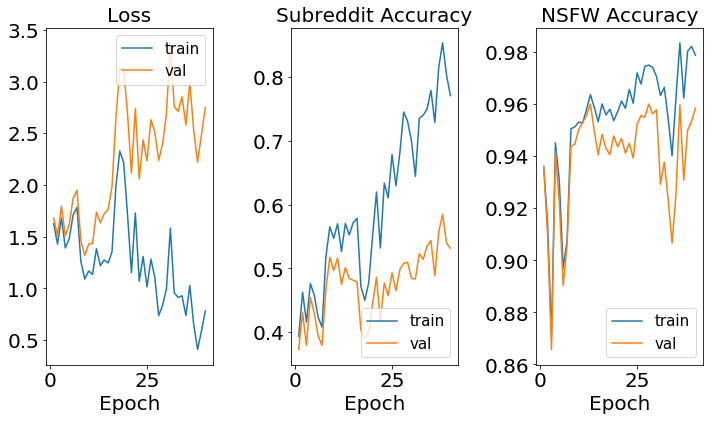

In [12]:
# Plot Loss and Accuracy
model.plot_loss_acc(data, save_address = '../../plots/', save_name = 'multitask_history', \
    title_font = 20, tick_font = 20, legend_font = 15, axis_font = 20)

# Confusion Matrix

In [12]:
y_val_pred_sub, y_val_pred_nsfw = session.run(model.prediction, {model.X_placeholder: data.X_val, \
    model.y_sbrd_placeholder: data.y_val, model.y_nsfw_placeholder: data.y_val_2, \
    model.is_training_placeholder:False})

y_val_pred_sub = np.argmax(y_val_pred_sub, axis = 1)
y_val_pred_nsfw = np.argmax(y_val_pred_nsfw, axis = 1)

Normalized confusion matrix


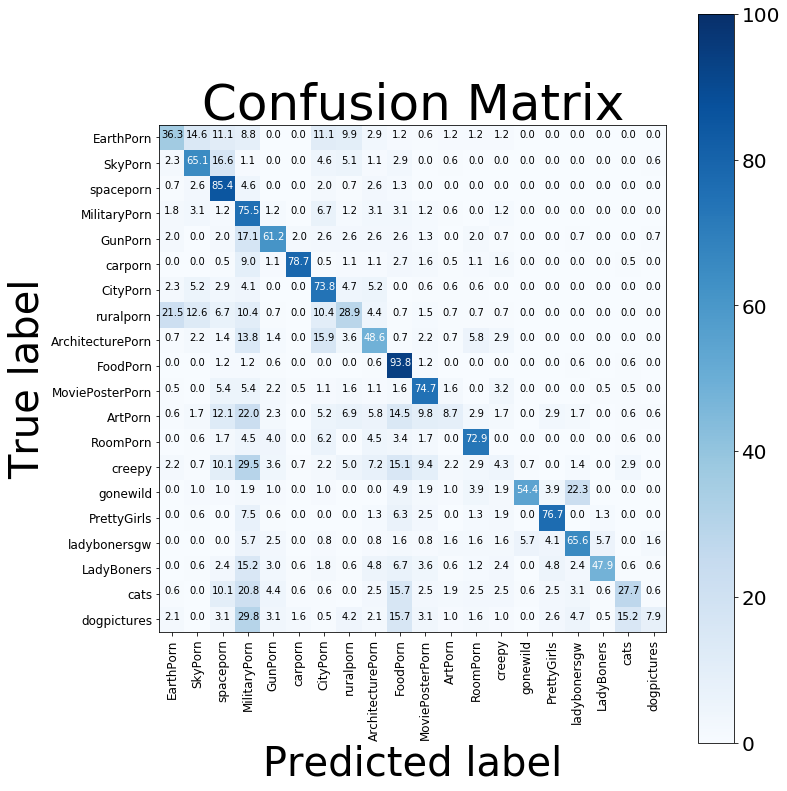

In [15]:
classes = [""] * len(dictionary)
for sub, ind in dictionary.items():
    classes[ind] = sub

conf = confusion_matrix(data.y_val, y_val_pred_sub)
plot_confusion_matrix(conf, classes=classes, normalize = True, tick_font = 12, box_font = 10, \
    axis_font = 40, title_font = 50, colorbar_font = 20,\
    left_space = 0.2, right_space = 1, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../plots/', save_name = 'multitask_confusion_subreddit')

Normalized confusion matrix


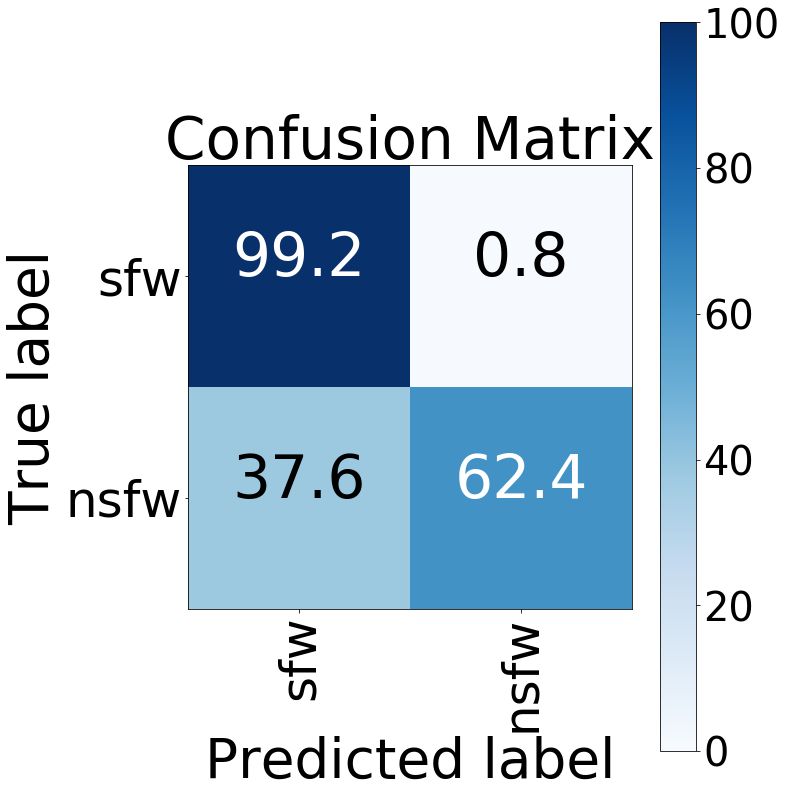

In [17]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_val_2, y_val_pred_nsfw)
plot_confusion_matrix(conf, classes=classes, normalize = True, figure_size = 11, tick_font = 50, box_font = 60, \
    axis_font = 55, title_font = 58, colorbar_font = 40,\
    left_space = 0.25, right_space = 0.95, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../plots/', save_name = 'multitask_confusion_nsfw')

# Visualization

In [87]:
def deprocess_X(X, rescale=False):
    return (X + data.mean_image) / 255.0

def compute_saliency_maps(X, y, model):
    saliency = None
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    #
    # Note: this is equivalent to scores[np.arange(N), y] we used in NumPy
    # for computing vectorized losses.
    correct_scores = tf.gather_nd(model.prediction[0], \
                                  tf.stack((tf.range(X.shape[0]), tf.cast(model.y_sbrd_placeholder, tf.int32)), axis=1))
    ###############################################################################
    # TODO: Implement this function. You should use the correct_scores to compute #
    # the loss, and tf.gradients to compute the gradient of the loss with respect #
    # to the input image stored in model.image.                                   #
    # Use the global sess variable to finally run the computation.                #
    # Note: model.image and model.labels are placeholders and must be fed values  #
    # when you call sess.run().                                                   #brd_
    ###############################################################################
    loss = -tf.reduce_sum(correct_scores)
    dx = tf.gradients(loss, model.X_placeholder)[0]
    saliency_val = tf.reduce_max(tf.abs(dx), axis=-1)
    saliency = session.run(saliency_val, feed_dict={model.X_placeholder:X, model.y_sbrd_placeholder:y, \
                                                model.is_training_placeholder:False})
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

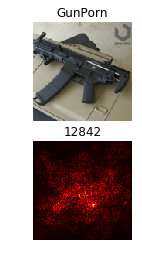

In [117]:
inverted_dictionary = {j:i for i,j in dictionary.items()}

def get_class_indices(y, dictionary, sample=5, subreddit=None):
    inverted_dictionary = {i:j for j, i in dictionary.items()}
    if subreddit:
        indices = [i for i in range(len(y)) if inverted_dictionary[y[i]] == subreddit]
        #indices = [i for i in range(len(y)) if y[i] == 1]
    else:
        indices = list(range(len(y)))
    random.shuffle(indices)
    return indices[:sample]

def show_saliency_maps(X, y, dictionary, mask):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]
    
    saliency = compute_saliency_maps(Xm, ym, model)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_X(Xm[i]))
        plt.axis('off')
        class_name = inverted_dictionary[ym[i]]
        #class_name = ym[i]
        plt.title(class_name)
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.savefig("../../plots/vis_multitask_"+str(mask[0]))
    plt.show()
    
    
indices = get_class_indices(data.y_train, dictionary, 6, "GunPorn")
show_saliency_maps(data.X_train, data.y_train, dictionary, [12842]) #indices)

# Evaluate on Test

In [19]:
cost, accuracy_sbrd, accuracy_nsfw = model.eval(data, session, "test")

subreddit test accuracy:55.1%
nsfw test accuracy:95.7%


### Confusion Matrix

In [25]:
y_test_pred_sub, y_test_pred_nsfw = session.run(model.prediction, {model.X_placeholder: data.X_test, \
    model.y_sbrd_placeholder: data.y_test, model.y_nsfw_placeholder: data.y_test_2, \
    model.is_training_placeholder:False})

y_test_pred_sub = np.argmax(y_test_pred_sub, axis = 1)
y_test_pred_nsfw = np.argmax(y_test_pred_nsfw, axis = 1)

Normalized confusion matrix


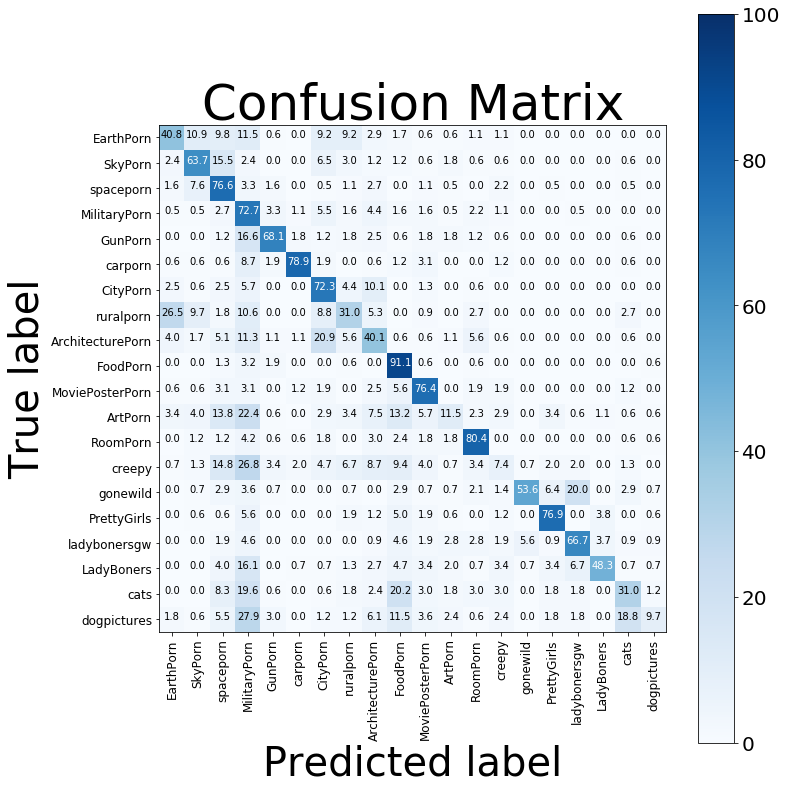

In [27]:
classes = [""] * len(dictionary)
for sub, ind in dictionary.items():
    classes[ind] = sub

conf = confusion_matrix(data.y_test, y_test_pred_sub)
plot_confusion_matrix(conf, classes=classes, normalize = True, tick_font = 12, box_font = 10, \
    axis_font = 40, title_font = 50, colorbar_font = 20,\
    left_space = 0.2, right_space = 1, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../plots/', save_name = 'test_multitask_confusion_subreddit')

Normalized confusion matrix


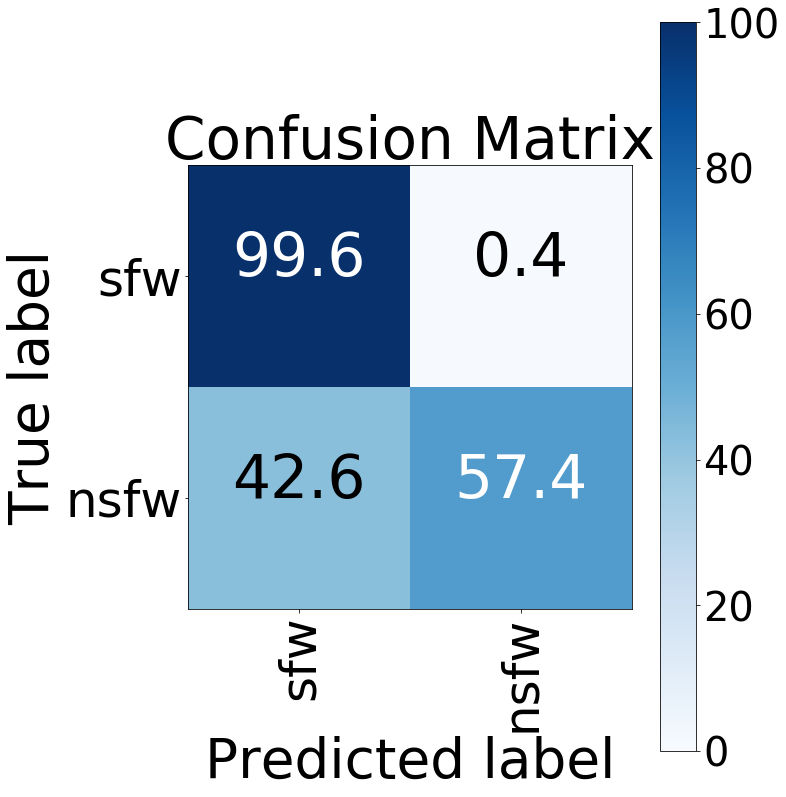

In [28]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_test_2, y_test_pred_nsfw)
plot_confusion_matrix(conf, classes=classes, normalize = True, figure_size = 11, tick_font = 50, box_font = 60, \
    axis_font = 55, title_font = 58, colorbar_font = 40,\
    left_space = 0.25, right_space = 0.95, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../plots/', save_name = 'test_multitask_confusion_nsfw')

# Hyperparameter Search

In [ ]:
train_config = TrainConfig(num_epochs=8, 
                    train_batch_size=64, 
                    print_every=1000)
modelHP = ResNet(model_config)
session = tf.Session()

def objective(args):

    tf.reset_default_graph()
    modelHP = ResNet(model_config)
    session = tf.Session()
    
    #train_config.num_epochs = args['Nepochs']
    train_config.lr_decay = args['decayRate']
    modelHP.config.learning_rate = args['learningRate']
    modelHP.config.sbrd_weight = args['costWeight']
    
    modelHP.train(data, session, train_config)
    cost, accuracy_sbrd, accuracy_nsfw = modelHP.eval(data, session, "val")
    
    saveList = {
        'accuracy_sbrd' : accuracy_sbrd,
        'accuracy_nsfw' : accuracy_nsfw,
        'cost' : cost,
        #'Nepochs' : args['Nepochs'],
        'learningRate' : args['learningRate'],
        'decayRate' : args['decayRate'],
        'costWeight' : args['costWeight']
    }    
    pickle.dump(saveList, open("../../hprOpt/hprPrmOpt_" + str(accuracy_sbrd) + "_"  + str(accuracy_nsfw) + "_" + str(cost) + ".dat", "wb"))
    
    modelHP.plot_loss_acc(data)
    
    return cost

def optimize():
    
    space = {
        #'Nepochs' : hpropt.hp.randint('Nepochs', 10),
        'learningRate' : hpropt.hp.loguniform('learningRate', -4, -1),
        'decayRate' : hpropt.hp.uniform('decayRate', 0.9, 1),
        'costWeight' : hpropt.hp.uniform('costWeight', 0.5, 1)
    }
    
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=500)
    print(best)
    
    return best

In [ ]:
optimize()

---------------------------------------------------------
Epoch 1 training finished in 96.547340 seconds
subreddit train accuracy:9.7%
nsfw train accuracy:91.5%
subreddit val accuracy:10.3%
nsfw val accuracy:92.0%
Epoch 1 evaluation finished in 14.464354 seconds
---------------------------------------------------------
Epoch 2 training finished in 95.591485 seconds
subreddit train accuracy:24.0%
nsfw train accuracy:92.2%
subreddit val accuracy:22.9%
nsfw val accuracy:92.5%
Epoch 2 evaluation finished in 14.167112 seconds
---------------------------------------------------------
Epoch 3 training finished in 95.168949 seconds
subreddit train accuracy:32.0%
nsfw train accuracy:92.6%
subreddit val accuracy:31.5%
nsfw val accuracy:92.8%
Epoch 3 evaluation finished in 14.271219 seconds
---------------------------------------------------------
Epoch 4 training finished in 95.646618 seconds
subreddit train accuracy:38.9%
nsfw train accuracy:93.7%
subreddit val accuracy:37.3%
nsfw val accuracy: